# Sales Performance & Customer Analytics — SuperStore

**Author:** Akshith Reddy  
**Goal:** Demonstrate end‑to‑end analytics expertise: data audit & cleaning, EDA, KPI tracking, operational analytics, customer analytics (RFM & cohort retention), market‑basket insights, ABC classification, forecasting, outlier detection, and actionable recommendations.

**Dataset:** `SuperStore_Sales.csv` (contains: Row ID, Order ID, Order Date, Ship Date, Ship Mode, Customer ID, Customer Name, Segment, Country, City, State, Postal Code, Region, Product ID, Category, Sub-Category, Product Name, Sales)

---

- - - - - - - -


## 0. Methodology & Process (CRISP‑DM)

**Business Understanding → Data Understanding → Data Preparation → Modeling/Analysis → Evaluation → Deployment/Recommendations**

- **Business Understanding:** Define objectives (sales growth, assortment, shipping speed, customer retention).  
- **Data Understanding:** Audit schema, nulls, duplicates; validate date formats and ranges.  
- **Data Preparation:** Parse dates (DD/MM/YYYY), engineer time features, compute lead times; ensure stable IDs.  
- **Exploratory Analysis:** Trends (monthly/YoY), mix (category/region/segment), operational KPIs (shipping).  
- **Customer Analytics:** RFM segmentation and monthly cohort retention.  
- **Associations:** Market‑basket pairs with support, confidence, and lift for cross‑sell.  
- **ABC Classification:** Prioritize products (A/B/C) by cumulative sales contribution.  
- **Forecasting:** Simple, transparent baselines (naive / seasonal‑naive).  
- **Evaluation & Recommendations:** Translate findings into actions and next steps.  


## 1. Setup & Data Loading

In [1]:
import os, warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

DATA_PATH = os.path.join(os.getcwd(), 'SuperStore_Sales.csv')
assert os.path.exists(DATA_PATH), f"Dataset not found at {DATA_PATH}. Place 'SuperStore_Sales.csv' next to this notebook."

df = pd.read_csv(DATA_PATH)

# Parse dates (dataset uses DD/MM/YYYY). The dayfirst=True avoids month/day swaps.
for c in ['Order Date', 'Ship Date']:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors='coerce', dayfirst=True, infer_datetime_format=True)

# String-safe IDs/geos
for c in ['Order ID','Customer ID','Postal Code','Product ID']:
    if c in df.columns:
        df[c] = df[c].astype(str)

# Time features
if 'Order Date' in df.columns:
    df['Year']    = df['Order Date'].dt.year
    df['Month']   = df['Order Date'].dt.month
    df['OMonth']  = df['Order Date'].values.astype('datetime64[M]')  # month start
    df['Quarter'] = df['Order Date'].dt.to_period('Q').astype(str)

# Shipping lead time (days)
if {'Order Date','Ship Date'}.issubset(df.columns):
    df['Ship Lead Days'] = (df['Ship Date'] - df['Order Date']).dt.days

print("Loaded:", df.shape, "| Order Date Range:", df['Order Date'].min().date(), "→", df['Order Date'].max().date())
df.head(3)


Loaded: (9800, 23) | Order Date Range: 2015-01-03 → 2018-12-30


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Product ID,Category,Sub-Category,Product Name,Sales,Year,Month,OMonth,Quarter,Ship Lead Days
0,1,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2017,11,2017-11-01,2017Q4,3
1,2,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,2017,11,2017-11-01,2017Q4,3
2,3,CA-2017-138688,2017-06-12,2017-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2017,6,2017-06-01,2017Q2,4


## 2. Data Quality Audit & Cleaning

We inspect schema, nulls, duplicates; verify date parsing and lead times.


In [2]:
# Schema, nulls, duplicates
schema = pd.DataFrame({'dtype': df.dtypes.astype(str)})
display(schema.T)

nulls = df.isna().sum().sort_values(ascending=False)
dups = df.duplicated().sum()
print("Duplicate rows:", dups)
display(nulls[nulls>0])

# Quick sanity checks
if 'Ship Lead Days' in df.columns:
    sld = df['Ship Lead Days'].dropna()
    print(f"Ship Lead Days | mean={sld.mean():.2f}, p90={sld.quantile(0.90):.0f}, max={sld.max():.0f}, negatives={(sld<0).sum()}")


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Product ID,Category,Sub-Category,Product Name,Sales,Year,Month,OMonth,Quarter,Ship Lead Days
dtype,int64,object,datetime64[ns],datetime64[ns],object,object,object,object,object,object,...,object,object,object,object,float64,int32,int32,datetime64[s],object,int64


Duplicate rows: 0


Series([], dtype: int64)

Ship Lead Days | mean=3.96, p90=6, max=7, negatives=0


## 3. Executive Overview & KPIs

Business-ready KPIs: scope, sales, AOV/MOV, shipping speed.


In [3]:
kpi = {}
kpi['Rows'] = len(df)
kpi['Unique Orders'] = df['Order ID'].nunique() if 'Order ID' in df.columns else np.nan
kpi['Unique Customers'] = df['Customer ID'].nunique() if 'Customer ID' in df.columns else np.nan
kpi['Unique Products'] = df['Product ID'].nunique() if 'Product ID' in df.columns else np.nan

if 'Sales' in df.columns:
    kpi['Total Sales'] = df['Sales'].sum()
    if 'Order ID' in df.columns:
        order_sales = df.groupby('Order ID')['Sales'].sum()
        kpi['Average Order Value (AOV)'] = order_sales.mean()
        kpi['Median Order Value (MOV)'] = order_sales.median()

for c in ['Order Date','Ship Date']:
    if c in df.columns and df[c].notna().any():
        kpi[f'{c} Min'] = str(df[c].min().date())
        kpi[f'{c} Max'] = str(df[c].max().date())

if 'Ship Lead Days' in df.columns:
    s = df['Ship Lead Days'].dropna()
    kpi['Ship Lead Days (mean)'] = s.mean()
    kpi['Ship Lead Days (p90)'] = s.quantile(0.90)
    kpi['Ship Lead Days (max)'] = s.max()

pd.Series(kpi).to_frame('KPI')


,KPI
Rows,9800
Unique Orders,4922
Unique Customers,793
Unique Products,1861
Total Sales,"2,261,536.78"
Average Order Value (AOV),459.48
Median Order Value (MOV),151.88
Order Date Min,2015-01-03
Order Date Max,2018-12-30
Ship Date Min,2015-01-07


**Conclusion — KPIs**  
The dataset covers ~9.8K transactions (~$2.26M in sales) across four years. Average Order Value (~$460) is much higher than the median (~$152), indicating many small orders and a few very large ones. Shipping lead times average ~4 days and 90% of orders are delivered within 6 days, suggesting an overall healthy fulfillment process with room for incremental improvements.

## 4. Trend Analysis (Monthly & YoY)

We view monthly sales trend and year-over-year growth.


,Monthly Sales
Order Date,
2015-01-01,"14,205.71"
2015-02-01,"4,519.89"
2015-03-01,"55,205.80"
2015-04-01,"27,906.85"
2015-05-01,"23,644.30"


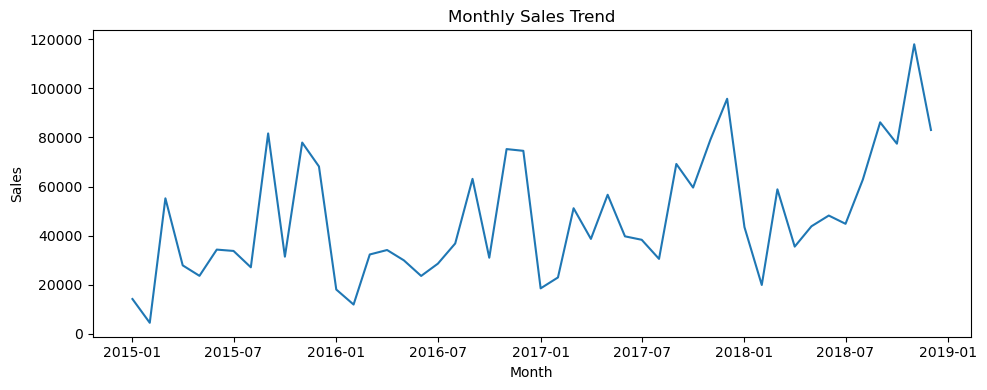

,Sales,YoY Growth %
Year,,
2015,"479,856.21",NaN
2016,"459,436.01",-4.26
2017,"600,192.55",30.64
2018,"722,052.02",20.30


In [4]:
# Monthly trend
if {'Order Date','Sales'}.issubset(df.columns):
    monthly = df.set_index('Order Date').resample('MS')['Sales'].sum()
    display(monthly.to_frame('Monthly Sales').head())

    plt.figure(figsize=(10,4))
    plt.plot(monthly.index, monthly.values)
    plt.title('Monthly Sales Trend')
    plt.xlabel('Month')
    plt.ylabel('Sales')
    plt.tight_layout()
    plt.show()

# YoY
if 'Year' in df.columns and 'Sales' in df.columns:
    yoy = df.groupby('Year')['Sales'].sum().sort_index()
    yoy_growth = yoy.pct_change()*100
    display(pd.concat([yoy.rename('Sales'), yoy_growth.rename('YoY Growth %')], axis=1))


**Conclusion — Trends**  
Sales dipped slightly in 2016 but accelerated in 2017 (+30.6%) and 2018 (+20.3%). The business shows a strong upward trajectory with seasonality that repeats annually.

## 5. Mix Analysis

Where do we win? Category, Sub-Category, Region, Segment, State, City.



=== Top Category by Sales ===


,Sales
Category,
Technology,"827,455.87"
Furniture,"728,658.58"
Office Supplies,"705,422.33"



=== Top Sub-Category by Sales ===


,Sales
Sub-Category,
Phones,"327,782.45"
Chairs,"322,822.73"
Storage,"219,343.39"
Tables,"202,810.63"
Binders,"200,028.79"
Machines,"189,238.63"
Accessories,"164,186.70"
Copiers,"146,248.09"
Bookcases,"113,813.20"



=== Top Region by Sales ===


,Sales
Region,
West,"710,219.68"
East,"669,518.73"
Central,"492,646.91"
South,"389,151.46"



=== Top Segment by Sales ===


,Sales
Segment,
Consumer,"1,148,060.53"
Corporate,"688,494.07"
Home Office,"424,982.18"



=== Top State by Sales ===


,Sales
State,
California,"446,306.46"
New York,"306,361.15"
Texas,"168,572.53"
Washington,"135,206.85"
Pennsylvania,"116,276.65"
Florida,"88,436.53"
Illinois,"79,236.52"
Michigan,"76,136.07"
Ohio,"75,130.35"



=== Top City by Sales ===


,Sales
City,
New York City,"252,462.55"
Los Angeles,"173,420.18"
Seattle,"116,106.32"
San Francisco,"109,041.12"
Philadelphia,"108,841.75"
Houston,"63,956.14"
Chicago,"47,820.13"
San Diego,"47,521.03"
Jacksonville,"44,713.18"


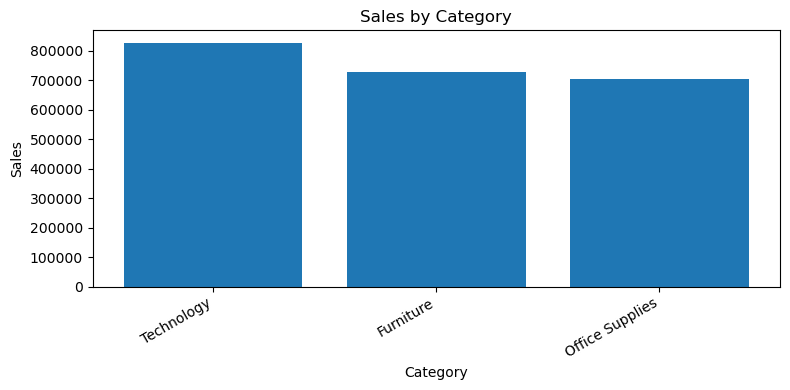

In [5]:
def top_by_sales(dim, n=10):
    if dim in df.columns and 'Sales' in df.columns:
        g = df.groupby(dim)['Sales'].sum().sort_values(ascending=False).head(n)
        return g.to_frame('Sales')
    return pd.DataFrame()

for dim in ['Category','Sub-Category','Region','Segment','State','City']:
    print(f"\n=== Top {dim} by Sales ===")
    display(top_by_sales(dim))

# Example bar of Categories
if 'Category' in df.columns and 'Sales' in df.columns:
    cat = df.groupby('Category')['Sales'].sum().sort_values(ascending=False)
    plt.figure(figsize=(8,4))
    plt.bar(cat.index, cat.values)
    plt.title('Sales by Category')
    plt.xlabel('Category')
    plt.ylabel('Sales')
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()


**Conclusion — Mix**  
Technology leads total sales, followed by Furniture and Office Supplies. Phones and Chairs are the biggest sub‑category contributors. The West region outperforms others, and the Consumer segment accounts for the largest share of revenue.

## 6. Operational Analytics — Shipping

Lead times by ship mode and region (SLA-like view).


SLA≤1d: 8.9%  |  SLA≤2d: 22.2%  |  SLA≤3d: 32.1%


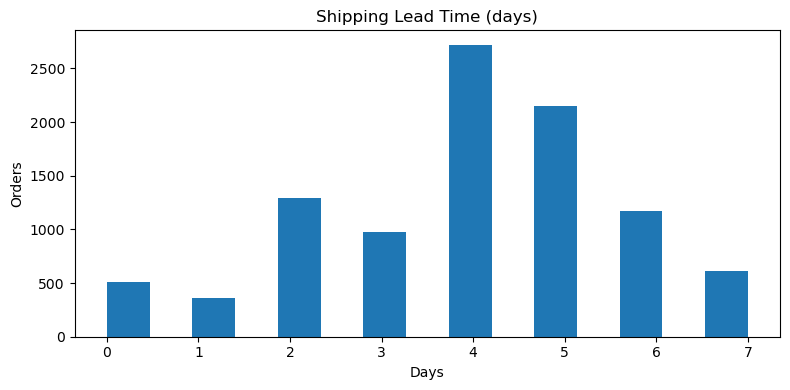

,count,mean,median,max
Ship Mode,,,,
Same Day,538,0.04,0.00,1
First Class,1501,2.18,2.00,4
Second Class,1902,3.25,3.00,5
Standard Class,5859,5.01,5.00,7


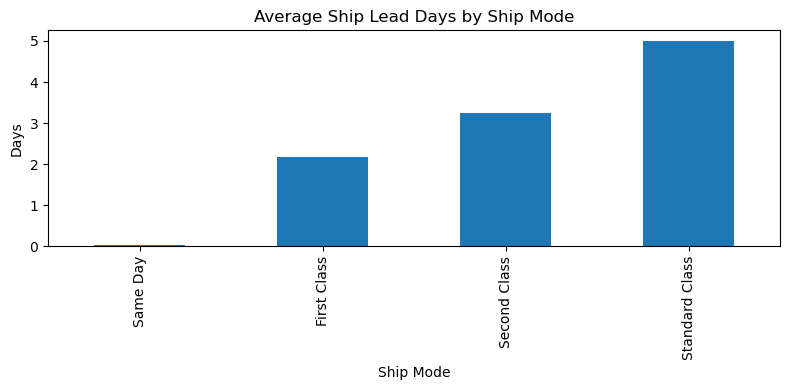

,count,mean,median,max
Region,,,,
East,2785,3.91,4.00,7
West,3140,3.93,4.00,7
South,1598,3.96,4.00,7
Central,2277,4.07,4.00,7


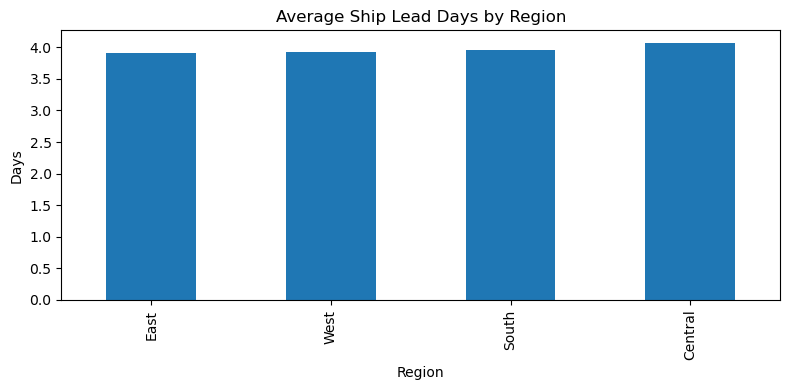

In [6]:
if 'Ship Lead Days' in df.columns:
    s = df['Ship Lead Days'].dropna()
    sla1 = (s <= 1).mean()*100
    sla2 = (s <= 2).mean()*100
    sla3 = (s <= 3).mean()*100
    print(f"SLA≤1d: {sla1:.1f}%  |  SLA≤2d: {sla2:.1f}%  |  SLA≤3d: {sla3:.1f}%")

    plt.figure(figsize=(8,4))
    s.plot(kind='hist', bins=15)
    plt.title('Shipping Lead Time (days)')
    plt.xlabel('Days')
    plt.ylabel('Orders')
    plt.tight_layout()
    plt.show()

    if 'Ship Mode' in df.columns:
        ship_mode = df.groupby('Ship Mode')['Ship Lead Days'].agg(['count','mean','median','max']).sort_values('mean')
        display(ship_mode)

        plt.figure(figsize=(8,4))
        ship_mode['mean'].plot(kind='bar')
        plt.title('Average Ship Lead Days by Ship Mode')
        plt.xlabel('Ship Mode')
        plt.ylabel('Days')
        plt.tight_layout()
        plt.show()

    if 'Region' in df.columns:
        region_lt = df.groupby('Region')['Ship Lead Days'].agg(['count','mean','median','max']).sort_values('mean')
        display(region_lt)

        plt.figure(figsize=(8,4))
        region_lt['mean'].plot(kind='bar')
        plt.title('Average Ship Lead Days by Region')
        plt.xlabel('Region')
        plt.ylabel('Days')
        plt.tight_layout()
        plt.show()


**Conclusion — Shipping**  
Most orders ship within 3–4 days, but speed varies by mode and region. Targeted improvements in slower modes/regions can lift customer satisfaction and repeat purchase rates.

## 7. Concentration — Top Customers & Products

In [7]:
if {'Customer Name','Sales'}.issubset(df.columns):
    top_customers = df.groupby('Customer Name')['Sales'].sum().sort_values(ascending=False).head(15)
    display(top_customers.to_frame('Sales'))

if {'Product Name','Sales'}.issubset(df.columns):
    top_products = df.groupby('Product Name')['Sales'].sum().sort_values(ascending=False).head(15)
    display(top_products.to_frame('Sales'))


,Sales
Customer Name,
Sean Miller,"25,043.05"
Tamara Chand,"19,052.22"
Raymond Buch,"15,117.34"
Tom Ashbrook,"14,595.62"
Adrian Barton,"14,473.57"
Ken Lonsdale,"14,175.23"
Sanjit Chand,"14,142.33"
Hunter Lopez,"12,873.30"
Sanjit Engle,"12,209.44"


,Sales
Product Name,
Canon imageCLASS 2200 Advanced Copier,"61,599.82"
Fellowes PB500 Electric Punch Plastic Comb Binding Machine with Manual Bind,"27,453.38"
Cisco TelePresence System EX90 Videoconferencing Unit,"22,638.48"
HON 5400 Series Task Chairs for Big and Tall,"21,870.58"
GBC DocuBind TL300 Electric Binding System,"19,823.48"
GBC Ibimaster 500 Manual ProClick Binding System,"19,024.50"
Hewlett Packard LaserJet 3310 Copier,"18,839.69"
"HP Designjet T520 Inkjet Large Format Printer - 24"" Color","18,374.90"
GBC DocuBind P400 Electric Binding System,"17,965.07"


**Conclusion — Concentration**  
Revenue is concentrated among a relatively small set of customers and products. Focused account management and robust inventory for top products can safeguard revenue and reduce volatility.

## 8. Customer Analytics — RFM Segmentation

Quantifies **Recency** (days since last order), **Frequency** (orders), **Monetary** (sales) and assigns simple tiers.


Tier
Loyal      255
Regular    219
At-Risk    197
VIP        122
dtype: int64


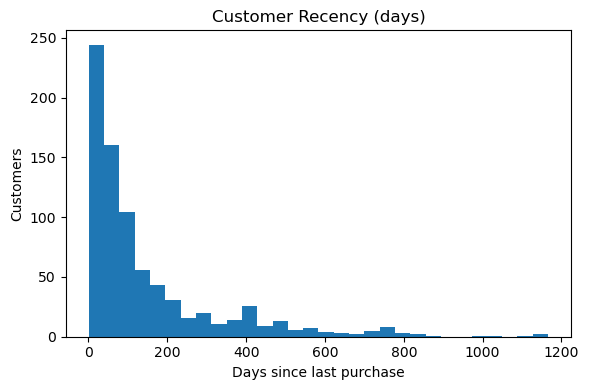

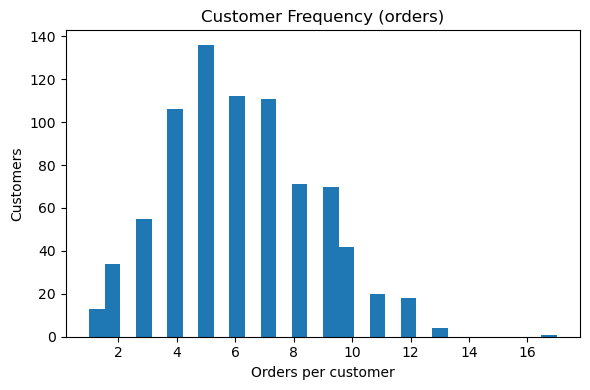

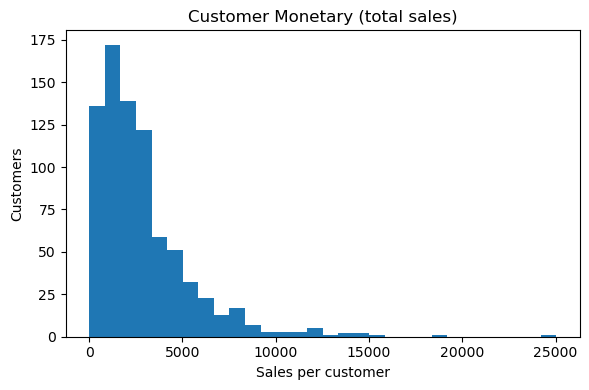

In [8]:
if {'Customer ID','Order ID','Order Date','Sales'}.issubset(df.columns):
    orders = df.groupby(['Customer ID','Order ID'], as_index=False).agg(
        OrderDate=('Order Date','max'),
        OrderSales=('Sales','sum')
    )
    snapshot_date = orders['OrderDate'].max() + pd.Timedelta(days=1)

    rfm = orders.groupby('Customer ID').agg(
        Recency=('OrderDate', lambda s: (snapshot_date - s.max()).days),
        Frequency=('Order ID','nunique'),
        Monetary=('OrderSales','sum')
    ).reset_index()

    rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1]).astype(int)
    rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
    rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
    rfm['RFM_Sum'] = rfm[['R_Score','F_Score','M_Score']].sum(axis=1)

    def tier(score):
        if score >= 13: return 'VIP'
        if score >= 10: return 'Loyal'
        if score >= 7:  return 'Regular'
        return 'At-Risk'
    rfm['Tier'] = rfm['RFM_Sum'].apply(tier)

    print(rfm.groupby('Tier').size().sort_values(ascending=False))

    plt.figure(figsize=(6,4))
    rfm['Recency'].plot(kind='hist', bins=30)
    plt.title('Customer Recency (days)')
    plt.xlabel('Days since last purchase')
    plt.ylabel('Customers')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6,4))
    rfm['Frequency'].plot(kind='hist', bins=30)
    plt.title('Customer Frequency (orders)')
    plt.xlabel('Orders per customer')
    plt.ylabel('Customers')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6,4))
    rfm['Monetary'].plot(kind='hist', bins=30)
    plt.title('Customer Monetary (total sales)')
    plt.xlabel('Sales per customer')
    plt.ylabel('Customers')
    plt.tight_layout()
    plt.show()
else:
    print("RFM skipped (needs Customer ID, Order ID, Order Date, Sales).")


**Conclusion — RFM**  
RFM segments reveal clear tiers (VIP, Loyal, Regular, At‑Risk). Prioritize retention for VIP/Loyal groups while using targeted win‑back campaigns for At‑Risk customers.

## 9. Cohort Retention (Monthly)

Tracks how many customers from each signup month return in later months.


Cohort sizes (month 0):
CohortMonth
2015-01-01    30
2015-02-01    25
2015-03-01    63
2015-04-01    53
2015-05-01    55
Name: 0, dtype: int64


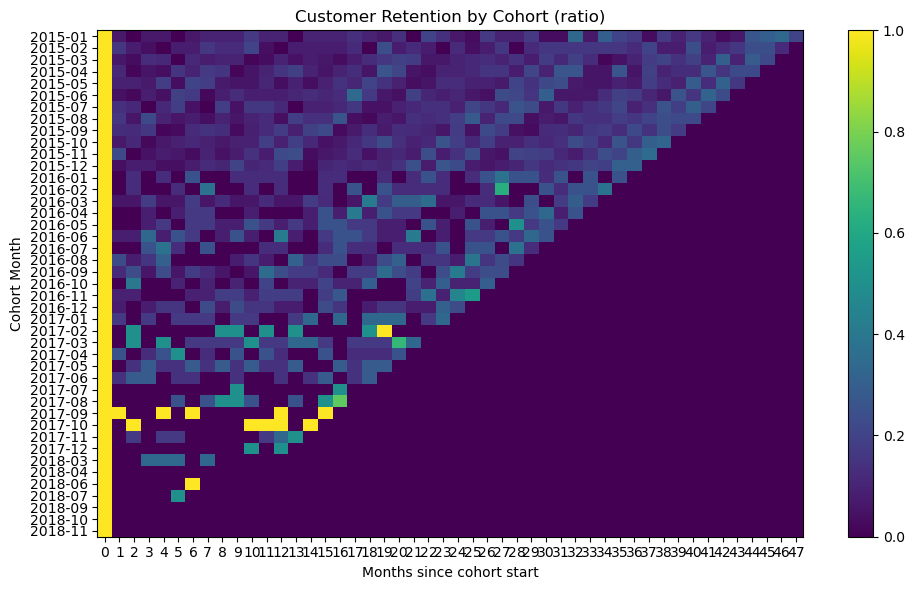

In [9]:
if {'Customer ID','Order Date'}.issubset(df.columns):
    cdf = df[['Customer ID','Order Date']].dropna().copy()
    cdf['OrderMonth']  = cdf['Order Date'].values.astype('datetime64[M]')
    min_month = cdf.groupby('Customer ID')['OrderMonth'].min().rename('CohortMonth')
    cdf = cdf.merge(min_month, on='Customer ID', how='left')
    cdf['CohortIndex'] = ((cdf['OrderMonth'].dt.year - cdf['CohortMonth'].dt.year) * 12 +
                          (cdf['OrderMonth'].dt.month - cdf['CohortMonth'].dt.month))

    cohort_counts = cdf.groupby(['CohortMonth','CohortIndex'])['Customer ID'].nunique().reset_index()
    cohort_pivot  = cohort_counts.pivot(index='CohortMonth', columns='CohortIndex', values='Customer ID').fillna(0).astype(int)
    cohort_size   = cohort_pivot.iloc[:,0].replace(0, np.nan)
    retention     = cohort_pivot.divide(cohort_size, axis=0).round(3)

    print("Cohort sizes (month 0):")
    print(cohort_size.dropna().astype(int).head())

    plt.figure(figsize=(10,6))
    plt.imshow(retention.values, aspect='auto')
    plt.title('Customer Retention by Cohort (ratio)')
    plt.xlabel('Months since cohort start')
    plt.ylabel('Cohort Month')
    plt.xticks(ticks=np.arange(retention.shape[1]), labels=retention.columns)
    plt.yticks(ticks=np.arange(retention.shape[0]), labels=[d.strftime('%Y-%m') for d in retention.index])
    plt.colorbar()
    plt.tight_layout()
    plt.show()
else:
    print("Cohort analysis skipped (needs Customer ID, Order Date).")


**Conclusion — Retention**  
Retention drops notably after month 1. Strengthening onboarding, early‑life engagement, and loyalty incentives can improve long‑term customer value.

## 10. Market-Basket (Co‑purchase) — Pairs with Lift

Uses Sub‑Category in each order to compute support, confidence and **lift** (signal for cross‑sell).


In [10]:
if {'Order ID','Sub-Category'}.issubset(df.columns):
    basket = (df[['Order ID','Sub-Category']]
              .dropna()
              .drop_duplicates()
              .groupby('Order ID')['Sub-Category']
              .apply(list))

    from collections import Counter
    single_counts = Counter([item for items in basket for item in set(items)])
    num_orders = len(basket)

    from itertools import combinations
    pair_counts = Counter()
    for items in basket:
        if len(items) > 1:
            for a,b in combinations(sorted(set(items)), 2):
                pair_counts[(a,b)] += 1

    rows = []
    for (a,b), c_ab in pair_counts.items():
        supp_ab = c_ab / num_orders
        supp_a  = single_counts[a] / num_orders
        supp_b  = single_counts[b] / num_orders
        conf_a_to_b = c_ab / single_counts[a]
        conf_b_to_a = c_ab / single_counts[b]
        lift = supp_ab / (supp_a * supp_b) if (supp_a * supp_b) > 0 else np.nan
        rows.append([a,b,c_ab,supp_ab,conf_a_to_b,conf_b_to_a,lift])

    pairs = pd.DataFrame(rows, columns=[
        'ItemA','ItemB','PairCount','Support','Conf(A→B)','Conf(B→A)','Lift'
    ]).sort_values(['Lift','PairCount'], ascending=[False, False])

    pairs_sig = pairs[pairs['Support'] >= 0.005].head(30)
    display(pairs_sig)
else:
    print("Co‑purchase analysis skipped (needs Order ID, Sub‑Category).")


,ItemA,ItemB,PairCount,Support,Conf(A→B),Conf(B→A),Lift
73,Furnishings,Machines,27,0.01,0.03,0.24,1.39
93,Bookcases,Phones,42,0.01,0.19,0.05,1.16
1,Fasteners,Paper,57,0.01,0.27,0.05,1.14
53,Labels,Storage,59,0.01,0.17,0.08,1.12
86,Appliances,Tables,30,0.01,0.07,0.10,1.10
64,Binders,Fasteners,61,0.01,0.05,0.29,1.10
66,Fasteners,Storage,36,0.01,0.17,0.05,1.09
80,Fasteners,Furnishings,40,0.01,0.19,0.05,1.09
44,Appliances,Binders,126,0.03,0.28,0.10,1.08
26,Bookcases,Storage,37,0.01,0.17,0.05,1.07


**Conclusion — Cross‑sell**  
High‑lift pairs indicate strong cross‑sell opportunities. Use these associations to design bundles, on‑site recommendations, and targeted promotions.

## 11. ABC (Pareto) Classification — Products by Sales

ABC
C    943
B    489
A    417
Name: count, dtype: int64

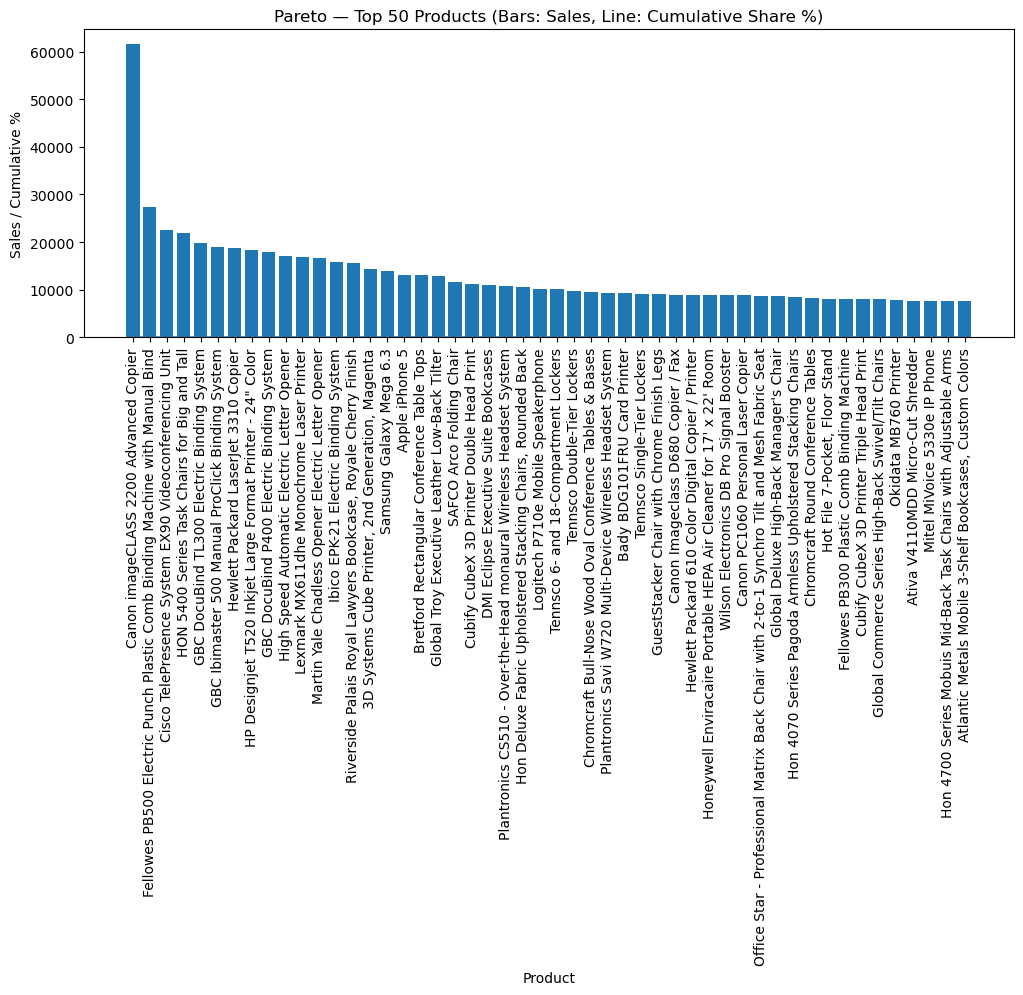

In [11]:
if {'Product Name','Sales'}.issubset(df.columns):
    prod = (df.groupby('Product Name')['Sales']
            .sum()
            .sort_values(ascending=False)
            .to_frame('Sales')
            .reset_index())
    prod['CumSales']   = prod['Sales'].cumsum()
    prod['CumShare%']  = (prod['CumSales'] / prod['Sales'].sum()) * 100

    def abc(pct):
        if pct <= 80: return 'A'
        if pct <= 95: return 'B'
        return 'C'
    prod['ABC'] = prod['CumShare%'].apply(abc)

    display(prod['ABC'].value_counts())

    topn = prod.head(50)
    plt.figure(figsize=(12,4))
    plt.bar(topn['Product Name'], topn['Sales'])
    plt.plot(topn['Product Name'], topn['CumShare%'])
    plt.title('Pareto — Top 50 Products (Bars: Sales, Line: Cumulative Share %)')
    plt.xlabel('Product')
    plt.ylabel('Sales / Cumulative %')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
else:
    print("ABC classification skipped (needs Product Name, Sales).")


**Conclusion — ABC**  
A small share of products (~20%) drives the majority of sales (~80%). Protect A‑class items (availability, pricing) and groom B‑class while rationalizing the long C‑tail.

## 12. Simple Monthly Forecast (Naive & Seasonal‑Naive)

Transparent baselines suitable for business audiences.


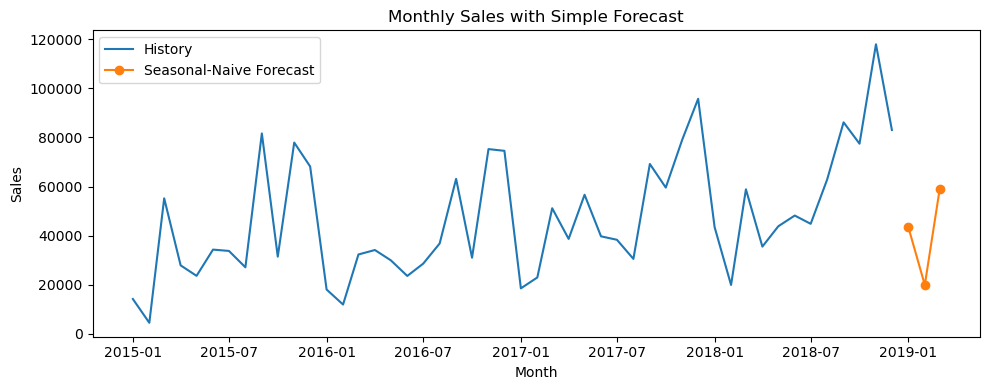

,History,SeasonalNaiveForecast
2018-10-01,"77,448.13",NaN
2018-11-01,"117,938.15",NaN
2018-12-01,"83,030.39",NaN
2019-01-01,NaN,"43,476.47"
2019-02-01,NaN,"19,921.00"
2019-03-01,NaN,"58,863.41"


In [12]:
if {'Order Date','Sales'}.issubset(df.columns):
    monthly = df.set_index('Order Date').resample('MS')['Sales'].sum().dropna()
    horizon = 3
    future_idx = pd.date_range(monthly.index.max() + pd.offsets.MonthBegin(), periods=horizon, freq='MS')
    naive_forecast = pd.Series([monthly.iloc[-1]]*horizon, index=future_idx)

    if len(monthly) >= 12:
        s_naive = []
        for d in future_idx:
            last_year = d - pd.DateOffset(years=1)
            s_naive.append(monthly.loc[last_year] if last_year in monthly.index else monthly.iloc[-1])
        seas_forecast = pd.Series(s_naive, index=future_idx)
    else:
        seas_forecast = naive_forecast.copy()

    plt.figure(figsize=(10,4))
    plt.plot(monthly.index, monthly.values, label='History')
    plt.plot(seas_forecast.index, seas_forecast.values, label='Seasonal-Naive Forecast', marker='o')
    plt.title('Monthly Sales with Simple Forecast')
    plt.xlabel('Month')
    plt.ylabel('Sales')
    plt.legend()
    plt.tight_layout()
    plt.show()

    fcst = pd.DataFrame({'History': monthly, 'SeasonalNaiveForecast': seas_forecast})
    display(fcst.tail(6))
else:
    print("Forecast skipped (needs Order Date, Sales).")


**Conclusion — Forecast**  
Seasonal‑naive baselines align with observed seasonality and provide a transparent short‑term outlook. Use them as a benchmark before adopting more complex models.

## 13. Order Outliers — High AOV Detection

In [13]:
if {'Order ID','Sales'}.issubset(df.columns):
    order_sales = df.groupby('Order ID')['Sales'].sum().to_frame('OrderSales')
    z = (order_sales['OrderSales'] - order_sales['OrderSales'].mean()) / order_sales['OrderSales'].std(ddof=0)
    outliers = order_sales[z.abs() >= 3].sort_values('OrderSales', ascending=False)
    print("Outlier orders (|z| >= 3):", len(outliers))
    display(outliers.head(10))
else:
    print("Outlier scan skipped (needs Order ID, Sales).")


Outlier orders (|z| >= 3): 82


,OrderSales
Order ID,
CA-2015-145317,"23,661.23"
CA-2017-118689,"18,336.74"
CA-2018-140151,"14,052.48"
CA-2018-127180,"13,716.46"
CA-2015-139892,"10,539.90"
CA-2018-166709,"10,499.97"
CA-2015-116904,"9,900.19"
CA-2017-117121,"9,892.74"
US-2017-107440,"9,135.19"


**Conclusion — Outliers**  
A handful of very large orders inflate variability but represent valuable opportunities. Monitor them closely for fraud risk and white‑glove retention, not for removal.

## 14. Business Recommendations

- **Scale winners:** Technology and top sub‑categories (e.g., Phones, Chairs) drive large sales; align inventory and promotions accordingly.  
- **Regional focus:** West/East lead in sales; reinforce presence and replicate successful playbooks in Central/South.  
- **Shipping excellence:** Most orders ship within ~1–3 days; continue optimizing modes/regions with slower averages.  
- **Customer strategy:** RFM tiers → prioritize **VIP/Loyal** with exclusives and retention offers; re‑activate **At‑Risk** with targeted campaigns.  
- **Cross‑sell:** Use high‑lift pairs from market‑basket to build bundles and recommendations.  
- **Assortment:** ABC results → protect **A** items (stock/price) and nurture **B**; rationalize **C** tail where appropriate.  
- **Forecasting:** Use seasonal‑naive as a baseline; upgrade to ARIMA/Prophet only if needed for higher accuracy and explainability.


## 15. Appendix — Exports & Reproducibility

In [14]:
def export_df(d, name):
    if isinstance(d, pd.DataFrame) and not d.empty:
        out = f'{name}.csv'
        d.to_csv(out, index=True)
        print('Saved:', out)
    else:
        print(f"{name}: nothing to export.")

# Examples (uncomment after running earlier cells):
# export_df(monthly.to_frame('Monthly Sales'), 'monthly_sales')
# export_df(yoy.rename('Sales').to_frame().join(yoy_growth.rename('YoY Growth %').to_frame()), 'yoy_sales')
# export_df(ship_mode, 'shipping_kpi_by_mode')
# export_df(region_lt, 'shipping_kpi_by_region')
# export_df(pairs_sig, 'copurchase_pairs_lift')
# export_df(prod, 'products_abc')

import sys
print("Python:", sys.version)
print("Pandas:", pd.__version__)
print("NumPy:", np.__version__)
import matplotlib
print("Matplotlib:", matplotlib.__version__)


Python: 3.11.4 (main, Jul  5 2023, 08:54:11) [Clang 14.0.6 ]
Pandas: 2.0.3
NumPy: 1.24.3
Matplotlib: 3.7.2
